# SetUp

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

from scipy.stats import boxcox

In [31]:
df = pd.read_csv("/Users/drewpeterson/Documents/Programming/Python/DataSets/LearningFuze_Data/LoansTrainingSet.csv", low_memory=False)

def update_column_names(columns):
    new_column_name_list = []
    for each_column in list(columns):
        split_title = each_column.split(" ")
        underscored_title = "_".join(split_title).lower()
        new_column_name_list.append(underscored_title)
    return new_column_name_list

df.columns = update_column_names(df.columns)

# Correct Columns & Identify NULLs

In [32]:
df.home_ownership = df.home_ownership.apply(lambda x: "Home Mortgage" if x == "HaveMortgage" else x)

df.purpose = df.purpose.apply(lambda x: "Other" if x == "other" else x)

df.monthly_debt = df.monthly_debt.str.replace("$", "").str.replace(",","").astype(float)

df.maximum_open_credit = df.maximum_open_credit.apply(lambda x: np.NaN if x == "#VALUE!" else float(x))

df.current_loan_amount = df.current_loan_amount.apply(lambda x: np.NaN if x==99999999 else x)

df.credit_score = df.credit_score.apply(lambda x: x/10 if x > 1000 else x)

# Duplicates

Step1: Fill NA with values

Step 2: Set all rows with duplicate loan_id equal to bank risk management safest option, make all rows with the same loan_id the same

Step 3: Remove duplicate rows (this deletes all rows with duplicate loan_ids)

In [33]:
# Impute Credit Score and Annual Income by the Customer_ID (reduces NULLs in these columns by 15,000)

df.credit_score = df.groupby(["customer_id"]).credit_score.transform(lambda x: x.fillna(x.min()))
df.annual_income = df.groupby(["customer_id"]).annual_income.transform(lambda x: x.fillna(x.min()))

Beyond just filling in NULLs, set all values of unqiue Loan_ID's equal to the min or max (depending on Bank Risk Management)

In [34]:
df.current_loan_amount = df.groupby(["loan_id"]).current_loan_amount.transform(lambda x: x.max())

df.credit_score = df.groupby(["loan_id"]).credit_score.transform(lambda x: x.min())

df.annual_income = df.groupby(["loan_id"]).annual_income.transform(lambda x: x.min())

df.months_since_last_delinquent = df.groupby(["loan_id"]).months_since_last_delinquent.transform(lambda x: x.min())

df.maximum_open_credit = df.groupby(["loan_id"]).maximum_open_credit.transform(lambda x: x.min())

df.bankruptcies = df.groupby(["loan_id"]).bankruptcies.transform(lambda x: x.max())

df.tax_liens = df.groupby(["loan_id"]).tax_liens.transform(lambda x: x.max())

df.monthly_debt = df.groupby(["loan_id"]).monthly_debt.transform(lambda x: x.max())

df.years_of_credit_history = df.groupby(["loan_id"]).years_of_credit_history.transform(lambda x: x.min())

df.number_of_open_accounts = df.groupby(["loan_id"]).number_of_open_accounts.transform(lambda x: x.min())

df.number_of_credit_problems = df.groupby(["loan_id"]).number_of_credit_problems.transform(lambda x: x.max())

df.current_credit_balance = df.groupby(["loan_id"]).current_credit_balance.transform(lambda x: x.max())

In [35]:
df.duplicated().sum()

41284

40,000+ Duplicated Rows

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
df.duplicated().sum()

0

Remove Duplicated Rows

# NULL Values

Structurally Missing Data:

Keep Categorical Nulls as Null
* Years in current Job
* Months since last delinquent

Impute Numerical Values
* Current Loan Amount
* Annual Income
* Credit Score
* Maxiumum Open Credit
* bankruptcies
* tax_liens

In [13]:
df.isnull().sum()

loan_id                              0
customer_id                          0
loan_status                          0
current_loan_amount                  0
term                                 0
credit_score                         0
years_in_current_job              8990
home_ownership                       0
annual_income                        0
purpose                              0
monthly_debt                         0
years_of_credit_history              0
months_since_last_delinquent    118258
number_of_open_accounts              0
number_of_credit_problems            0
current_credit_balance               0
maximum_open_credit                  0
bankruptcies                         0
tax_liens                            0
dtype: int64

Removing Small Number of NULLs 

Null values in maxiumum_open_credit (2 rows) and tax_liens (22 rows) represent Less than 1% of Data

Remove Observations where those columns are NULL

In [38]:
df.dropna(subset = ["maximum_open_credit", "tax_liens"], inplace=True)

Bankruptcies

Related to number_of_credit_problems (categorical numerical has only 12 possible values)

Groupby number_of_credit_problems, impute the median

In [39]:
df.bankruptcies = df.groupby("number_of_credit_problems").bankruptcies.transform(lambda x: x.fillna(x.median()))

Current Loan Amount

Current Loan Amount may be related to the purpose of the loan

GroupBy all the categoricals, except for years_in_current_job (has nulls)

In [40]:
df.current_loan_amount = df.groupby(["purpose", "loan_status", "term", "home_ownership"]).current_loan_amount.transform(lambda x: x.fillna(x.median()));

<Axes: xlabel='purpose'>

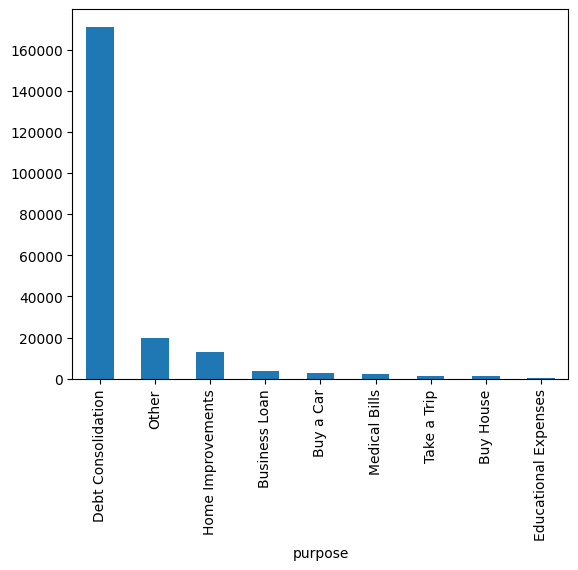

In [39]:
df.purpose.value_counts().plot(kind="bar")

In [45]:
df.groupby(["purpose", "loan_status", "home_ownership", "term"]).current_loan_amount.median().reset_index()

,purpose,loan_status,home_ownership,term,current_loan_amount
0,Business Loan,Charged Off,Home Mortgage,Long Term,23978.0
1,Business Loan,Charged Off,Home Mortgage,Short Term,14315.0
2,Business Loan,Charged Off,Own Home,Long Term,20444.0
3,Business Loan,Charged Off,Own Home,Short Term,9908.0
4,Business Loan,Charged Off,Rent,Long Term,17635.0
...,...,...,...,...,...
102,Take a Trip,Fully Paid,Home Mortgage,Short Term,4880.0
103,Take a Trip,Fully Paid,Own Home,Long Term,9938.0
104,Take a Trip,Fully Paid,Own Home,Short Term,5033.0
105,Take a Trip,Fully Paid,Rent,Long Term,6703.0


<Axes: >

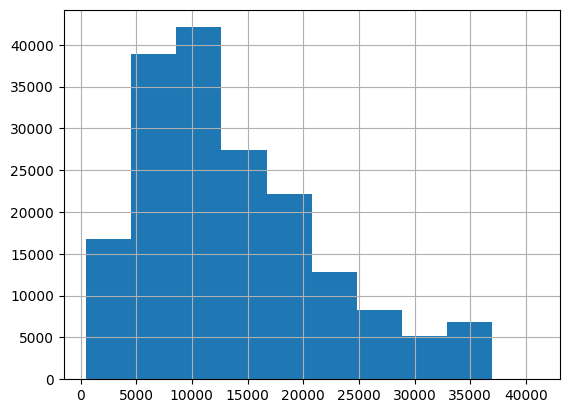

In [42]:
df.current_loan_amount.hist()

Credit Score & Annual Income

Group by categoricals relevant for each

In [41]:
df.credit_score = df.groupby(["purpose", "loan_status", "term"]).credit_score.transform(lambda x: x.fillna(x.median()))
df.annual_income = df.groupby(["purpose", "loan_status", "home_ownership"]).annual_income.transform(lambda x: x.fillna(x.median()))

In [ ]:
#df.dropna(subset=["credit_score"], inplace=True)

# Months Since Last Delinquent

Null Values in Months Since Last Delinquent

Some Null Values in Months Since Last Delinquent are Structurally Missing, for cases where a person has not ever been delinquent on a payment

However, if an observation has credit problems, but still has a NA in months since last delinquent, then can assume this data is missing at random

Step 1: 
Impute the median months since last delinquent as other people with the same number of credit problems 


Step 2: 
Fill in remaining missing values with a relevant value that reflects positively on not having ever been delinquent (200)


In [42]:
df.months_since_last_delinquent.isnull().sum()

118258

In [120]:
df[(df.months_since_last_delinquent.isnull()) & (df.number_of_credit_problems >= 1)]

,current_loan_amount,credit_score,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,...,purpose_debt_consolidation,purpose_other,purpose_business_loan,purpose_home_improvements,purpose_buy_house,purpose_buy_a_car,purpose_medical_bills,purpose_take_a_trip,home_encoded_mortgage,home_encoded_own
5,10208.0,716.0,41853.0,561.52,13.2,NaN,4,1,2289,4671.0,...,0,0,1,0,0,0,0,0,0,0
16,12142.0,744.0,65605.0,984.07,21.0,NaN,5,1,11514,17262.0,...,1,0,0,0,0,0,0,0,1,0
22,7228.0,739.0,71439.5,439.56,17.8,NaN,13,1,8488,15866.0,...,1,0,0,0,0,0,0,0,1,0
57,7068.0,734.0,50510.0,425.68,21.3,NaN,7,1,4178,6850.0,...,0,1,0,0,0,0,0,0,0,1
59,9942.0,727.0,52825.0,1360.25,14.3,NaN,11,1,34163,43080.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256906,7340.0,736.0,53867.0,220.04,26.4,NaN,4,1,6690,9682.0,...,1,0,0,0,0,0,0,0,0,0
256926,10393.0,736.0,53867.0,647.97,31.3,NaN,8,1,8997,44320.0,...,1,0,0,0,0,0,0,0,0,0
256943,10157.0,744.0,121884.0,598.25,14.3,NaN,6,1,8738,11682.0,...,1,0,0,0,0,0,0,0,1,0
256961,8721.0,726.0,38649.0,811.63,15.1,NaN,9,1,3860,13592.0,...,1,0,0,0,0,0,0,0,1,0


Sam Method

In [128]:
df.loc[((df.months_since_last_delinquent.isnull()) & (df.number_of_credit_problems >= 1)), "months_since_last_delinquent"] = 200

In [134]:
df[(df.months_since_last_delinquent < 200)].months_since_last_delinquent.median()

32.0

ALTERNATIVE METHOD

In [43]:
df.isnull().sum()

loan_id                              0
customer_id                          0
loan_status                          0
current_loan_amount                  0
term                                 0
credit_score                         0
years_in_current_job              8990
home_ownership                       0
annual_income                        0
purpose                              0
monthly_debt                         0
years_of_credit_history              0
months_since_last_delinquent    118258
number_of_open_accounts              0
number_of_credit_problems            0
current_credit_balance               0
maximum_open_credit                  0
bankruptcies                         0
tax_liens                            0
dtype: int64

<Axes: >

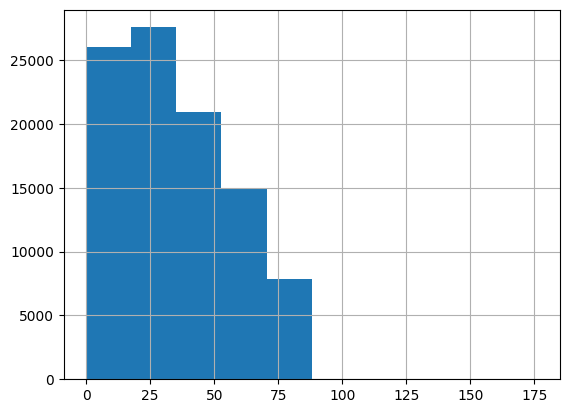

In [52]:
df.months_since_last_delinquent.hist()

In [65]:
test_df = df.loc[((df.months_since_last_delinquent.isnull()) & (df.number_of_credit_problems > 0))]

In [71]:
test_df.months_since_last_delinquent.value_counts()

months_since_last_delinquent
40.0    13237
42.0     1040
42.5      247
41.0       30
17.0        3
49.0        2
25.5        1
1.0         1
Name: count, dtype: int64

In [67]:
test_df.months_since_last_delinquent = df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median()))

/var/folders/75/8cznfb4d2j56mrdwqyh36s3w0000gn/T/ipykernel_8393/409336867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.months_since_last_delinquent = df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median()))


(14561,)

In [ ]:
df.months_since_last_delinquent.hist()

For Null Values in Months Since Last Delinquent

If they have credit problems, then can assume this data is not structurally missing, but that it is just missing at random

Fill in with the median months since last delinquent of the dataset that have credit problems over 0 (40 months)


A step further: 

Fill 

First Go

In [17]:
df.loc[((df.months_since_last_delinquent.isnull()) & (df.number_of_credit_problems > 0)), "months_since_last_delinquent"] = df[(df.number_of_credit_problems > 0)].months_since_last_delinquent.median()

Second Attempt

In [ ]:
df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median()))

Locate the rows where months since Last Deliquent is Null, and the Number of Credit Problems is Greater than 0
* These columns are likely missing the months since delinquent at random, not because they have never been delinquent on a payment
* Fill in the missing values of months since last delinquent with the median months since last delinquent of the people with the same number of credit problems

In [75]:
df.loc[((df.months_since_last_delinquent.isnull()) & (df.number_of_credit_problems > 0)), "months_since_last_delinquent"] = df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median()))

Fill in the Remaining Null Values in Months Since last Delinquent 
* (assume these are missing values in months since last delinquent because they have never been delinquent)
* This is a good thing, if they have never been delinquent on a payment, then set them equal to a number in the range of the highest months since last dleinquent (highest observation is 176, so fill NAs with 200)

In [79]:
df.months_since_last_delinquent = df.months_since_last_delinquent.fillna(200)

<Axes: >

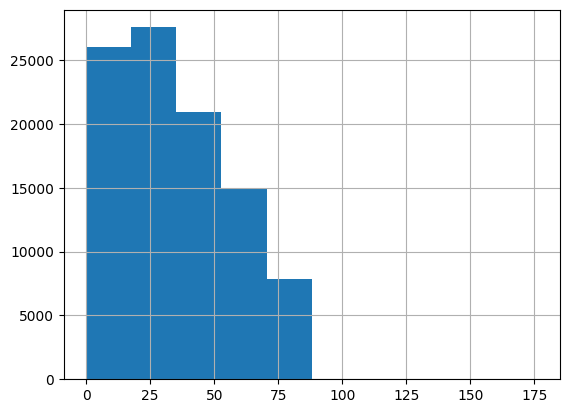

In [73]:
df.months_since_last_delinquent.hist()

In [76]:
df.months_since_last_delinquent.describe()

count    111979.000000
mean         35.706311
std          20.415939
min           0.000000
25%          19.000000
50%          37.000000
75%          47.000000
max         176.000000
Name: months_since_last_delinquent, dtype: float64

<Axes: >

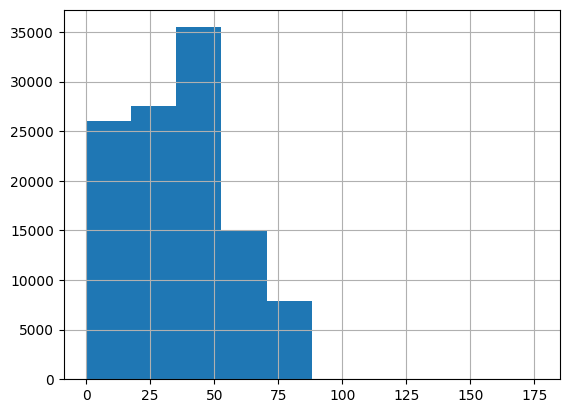

In [77]:
df.months_since_last_delinquent.hist()

In [78]:
df.months_since_last_delinquent.isnull().sum()

103697

<Axes: >

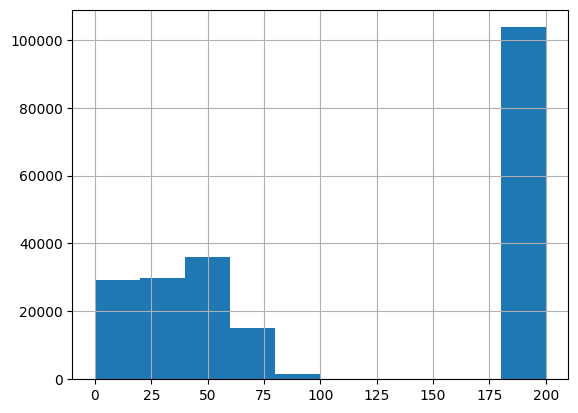

In [81]:
df.months_since_last_delinquent.hist()

In [53]:
df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median()))

5         40.0
16        40.0
22        40.0
36        55.0
38        21.0
          ... 
256959    80.0
256960    47.0
256961    40.0
256971    63.0
256977    40.0
Name: months_since_last_delinquent, Length: 28215, dtype: float64

Length

If the below code are the same length, then I believe it should be good to do the second attempt

In [44]:
df.loc[((df.months_since_last_delinquent.isnull()) & (df.number_of_credit_problems > 0)), "months_since_last_delinquent"].shape

(14561,)

In [45]:
df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median())).shape

(28215,)

In [51]:
df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.median()

number_of_credit_problems
1     40.0
2     42.0
3     42.5
4     40.0
5     41.0
6     42.5
7     40.0
8     25.5
9     49.0
10    17.0
11     1.0
Name: months_since_last_delinquent, dtype: float64

In [22]:
df[(df.number_of_credit_problems ==1 )].months_since_last_delinquent.median()

40.0

In [25]:
df[(df.number_of_credit_problems ==4)].months_since_last_delinquent.median()

40.0

In [28]:
df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.transform(lambda x: x.fillna(x.median()))

5         40.0
16        40.0
22        40.0
36        55.0
38        21.0
          ... 
256959    80.0
256960    47.0
256961    40.0
256971    63.0
256977    40.0
Name: months_since_last_delinquent, Length: 28215, dtype: float64

In [27]:
df[(df.number_of_credit_problems > 0)].groupby("number_of_credit_problems").months_since_last_delinquent.median()

number_of_credit_problems
1     40.0
2     40.0
3     40.0
4     40.0
5     40.0
6     40.0
7     40.0
8     26.0
9     49.0
10    40.0
11    20.5
Name: months_since_last_delinquent, dtype: float64

In [21]:
df[(df.number_of_credit_problems > 0)].number_of_credit_problems.value_counts()

number_of_credit_problems
1     24681
2      2480
3       665
4       216
5        99
6        36
7        14
8        11
10        6
9         5
11        2
Name: count, dtype: int64

<Axes: >

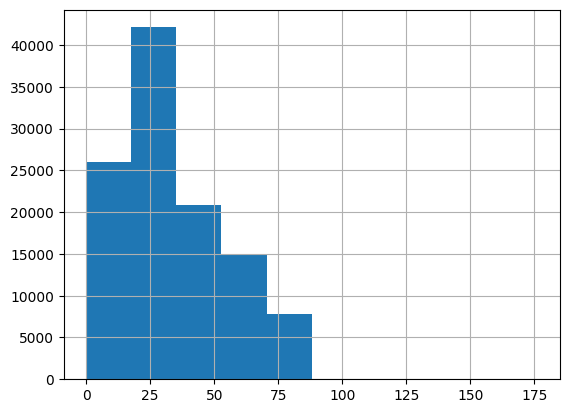

In [149]:
df.months_since_last_delinquent.hist()

<Axes: >

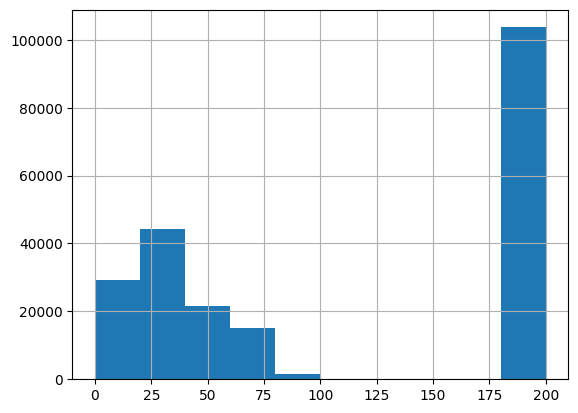

In [151]:
df.months_since_last_delinquent.hist()

# Encoding

Binary encoding

Term & Loan Status

In [154]:
df["term_encoded"] = df.term.apply(lambda x: 1 if x=="Long Term" else 0)
df["loan_status_encoded"] = df.loan_status.apply(lambda x: 1 if x=="Fully Paid" else 0)

Ordinal Encoding

Years in Current Job

In [155]:
df.years_in_current_job = df.years_in_current_job.fillna(0)
df["years_in_job_encoded"] = df.years_in_current_job.map({0:0, "< 1 year":0.5, "1 year":1, "2 years":2, "3 years":3, "4 years":4, "5 years":5, "6 years":6, "7 years":7, "8 years":8, "9 years":9, "10+ years":10})

One Hot Encoding

Home Ownership & Purpose

In [156]:
one = ce.OneHotEncoder(use_cat_names=True)
df[["home_encoded_mortgage", "home_encoded_own"]] = one.fit_transform(df.home_ownership).iloc[:,:2]

In [157]:
one = ce.OneHotEncoder(use_cat_names=True)
df[one.fit_transform(df.purpose).iloc[:,:-1].columns] = one.fit_transform(df.purpose).iloc[:,:-1]
df.columns = update_column_names(df.columns)

In [158]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,...,home_encoded_mortgage,home_encoded_own,purpose_debt_consolidation,purpose_other,purpose_business_loan,purpose_home_improvements,purpose_buy_house,purpose_buy_a_car,purpose_medical_bills,purpose_take_a_trip
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,Fully Paid,11520.0,Short Term,741.0,10+ years,Home Mortgage,33694.0,Debt Consolidation,...,1,0,1,0,0,0,0,0,0,0
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,Fully Paid,3441.0,Short Term,734.0,4 years,Home Mortgage,42269.0,Other,...,1,0,0,1,0,0,0,0,0,0
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,Fully Paid,21029.0,Short Term,747.0,10+ years,Home Mortgage,90126.0,Debt Consolidation,...,1,0,1,0,0,0,0,0,0,0
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,Fully Paid,18743.0,Short Term,747.0,10+ years,Own Home,38072.0,Debt Consolidation,...,0,1,1,0,0,0,0,0,0,0
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Fully Paid,11731.0,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,...,0,0,1,0,0,0,0,0,0,0


Drop ID & Categorical Columns

In [159]:
df.drop(columns = ["loan_id", "customer_id", "loan_status", "term", "home_ownership", "years_in_current_job", "purpose"],axis=1, inplace=True)

In [162]:
df

,current_loan_amount,credit_score,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,...,home_encoded_mortgage,home_encoded_own,purpose_debt_consolidation,purpose_other,purpose_business_loan,purpose_home_improvements,purpose_buy_house,purpose_buy_a_car,purpose_medical_bills,purpose_take_a_trip
0,11520.0,741.0,33694.0,584.03,12.3,41.0,10,0,6760,16056.0,...,1,0,1,0,0,0,0,0,0,0
1,3441.0,734.0,42269.0,1106.04,26.3,200.0,17,0,6262,19149.0,...,1,0,0,1,0,0,0,0,0,0
2,21029.0,747.0,90126.0,1321.85,28.8,200.0,5,0,20967,28335.0,...,1,0,1,0,0,0,0,0,0,0
3,18743.0,747.0,38072.0,751.92,26.2,200.0,9,0,22529,43915.0,...,0,1,1,0,0,0,0,0,0,0
4,11731.0,746.0,50025.0,355.18,11.5,200.0,12,0,17391,37081.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256977,11953.0,717.0,39844.0,982.82,11.7,32.0,9,1,4176,4783.0,...,1,0,1,0,0,0,0,0,0,0
256979,3911.0,736.0,53867.0,1706.58,19.9,200.0,16,0,43992,44080.0,...,0,0,1,0,0,0,0,0,0,0
256980,5078.0,737.0,77186.0,1376.47,19.1,47.0,9,0,1717,9758.0,...,0,1,1,0,0,0,0,0,0,0
256981,12116.0,746.0,52504.0,297.96,15.1,82.0,8,0,3315,20090.0,...,1,0,1,0,0,0,0,0,0,0


In [161]:
df.isnull().sum()

current_loan_amount             0
credit_score                    0
annual_income                   0
monthly_debt                    0
years_of_credit_history         0
months_since_last_delinquent    0
number_of_open_accounts         0
number_of_credit_problems       0
current_credit_balance          0
maximum_open_credit             0
bankruptcies                    0
tax_liens                       0
term_encoded                    0
loan_status_encoded             0
years_in_job_encoded            0
home_encoded_mortgage           0
home_encoded_own                0
purpose_debt_consolidation      0
purpose_other                   0
purpose_business_loan           0
purpose_home_improvements       0
purpose_buy_house               0
purpose_buy_a_car               0
purpose_medical_bills           0
purpose_take_a_trip             0
dtype: int64

# Transform

Transform helps make data normally distributed

Trying to reduce skew in data, in preparation for Machine Learning Models

BoxCox does not handle 0

In [168]:
for each_column in df.columns:
    name = "box_" + each_column
    name, lamb = boxcox(df[each_column])
    df["each_column"] = pd.Series(name)

ValueError: Data must be positive.

Log Transformation

In [193]:
for each_column in df.columns:
    df[each_column] = np.log1p(df[each_column])

In [194]:
df

,current_loan_amount,credit_score,annual_income,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,...,home_encoded_mortgage,home_encoded_own,purpose_debt_consolidation,purpose_other,purpose_business_loan,purpose_home_improvements,purpose_buy_house,purpose_buy_a_car,purpose_medical_bills,purpose_take_a_trip
0,0.278013,0.271846,0.279741,0.271132,0.248584,0.259069,0.246148,0.000000,0.277042,0.278578,...,0.191042,0.000000,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.275680,0.271819,0.280073,0.272966,0.255797,0.267347,0.251952,0.000000,0.276896,0.278866,...,0.191042,0.000000,0.000000,0.191042,0.0,0.0,0.0,0.0,0.0,0.0
2,0.279016,0.271870,0.281110,0.273434,0.256514,0.267347,0.235907,0.000000,0.279011,0.279480,...,0.191042,0.000000,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.278831,0.271870,0.279921,0.271889,0.255767,0.267347,0.244812,0.000000,0.279125,0.280128,...,0.000000,0.191042,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.278045,0.271866,0.280313,0.269503,0.247819,0.267347,0.248306,0.000000,0.278709,0.279882,...,0.000000,0.000000,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256977,0.278077,0.271750,0.279987,0.272646,0.248017,0.257313,0.244812,0.191042,0.276087,0.276364,...,0.191042,0.000000,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
256979,0.275951,0.271827,0.280416,0.274075,0.253423,0.267347,0.251358,0.000000,0.280130,0.280133,...,0.000000,0.000000,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
256980,0.276485,0.271830,0.280906,0.273538,0.253049,0.259969,0.244812,0.000000,0.274090,0.277720,...,0.000000,0.191042,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
256981,0.278101,0.271866,0.280381,0.268878,0.250775,0.263217,0.243235,0.000000,0.275600,0.278943,...,0.191042,0.000000,0.191042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


array([[<Axes: title={'center': 'current_loan_amount'}>,
        <Axes: title={'center': 'credit_score'}>,
        <Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'monthly_debt'}>,
        <Axes: title={'center': 'years_of_credit_history'}>],
       [<Axes: title={'center': 'months_since_last_delinquent'}>,
        <Axes: title={'center': 'number_of_open_accounts'}>,
        <Axes: title={'center': 'number_of_credit_problems'}>,
        <Axes: title={'center': 'current_credit_balance'}>,
        <Axes: title={'center': 'maximum_open_credit'}>],
       [<Axes: title={'center': 'bankruptcies'}>,
        <Axes: title={'center': 'tax_liens'}>,
        <Axes: title={'center': 'term_encoded'}>,
        <Axes: title={'center': 'loan_status_encoded'}>,
        <Axes: title={'center': 'years_in_job_encoded'}>],
       [<Axes: title={'center': 'home_encoded_mortgage'}>,
        <Axes: title={'center': 'home_encoded_own'}>,
        <Axes: title={'center': 'purpose_debt_

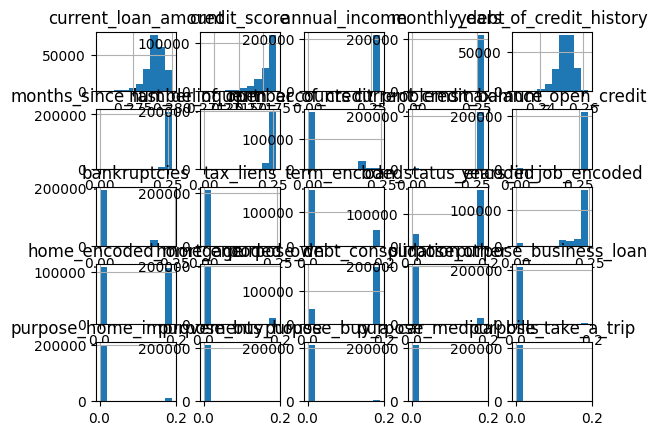

In [195]:
df.hist()